In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from activations import Cosine
from networks import WHVIRegression
from layers import WHVILinear
from torch_datasets import ToyDataset

In [2]:
torch.manual_seed(0)  # Seed for reproducibility

# Data
dataset = ToyDataset(n=128)
data_loader = DataLoader(dataset, batch_size=64)

In [3]:
net = WHVIRegression([
    nn.Linear(1, 128),
    Cosine(),
    WHVILinear(128, lambda_=1e-5),
    Cosine(),
    WHVILinear(128, lambda_=1e-5),
    Cosine(),
    nn.Linear(128, 1)
])

gamma=0.0005
p = 0.3
optimizer = optim.Adam(net.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: (1 + gamma * t)**(-p))

In [4]:
# TODO why is MNLL not changing in the fixed variance version???
net.train_model(data_loader, optimizer, epochs1=500, epochs2=50000)

[Opt. var.] KL = 33.83, MNLL = 0.29: 100%|██████████| 50000/50000 [26:22<00:00, 31.59it/s]        


In [5]:
net.eval()
net.eval_samples = 500
x_test = torch.reshape(torch.linspace(-2, 3, 1000), (-1, 1))
y_test = dataset.f(x_test)
y_pred = net(x_test)

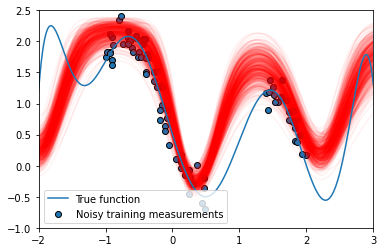

In [6]:
plt.figure()
plt.ylim(-1, 2.5)
plt.xlim(-2, 3)
for i in range(y_pred.size()[2]):
    plt.plot(x_test, y_pred[..., i].detach(), c='r', alpha=0.05)
plt.scatter(dataset.x, dataset.y, ec='k', label='Noisy training measurements')
plt.plot(x_test, y_test, label='True function')
plt.legend()
plt.show()